In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

## План лекции
----

- Проблема bias-variance tradeoff. Баланс между variance и bias.
- Общий подход к композициям алгоритмов.
- Метод bootstrap.
- Метод bagging.
- RSM (random subsampling method).
- RandomForest
  * алгоритм и ооb
  * важности признаков
- Boosting
  * adaboost
- Blending, stacking

### Что вообще такое ансамбль?

-----

Ансамбль моделей - это некоторый набор моделей-предсказателей (моделей классификаторов или моделей регрессоров), которые вместе могут дать согласованный (средний) ответ. Ансамбли довольно популярны на практике в классическом машинном обучении, так как используя несколько предсказателей, которые пытаются получить одну и туже переменную, в большинстве кейсов результат предсказания будет намного точнее, чем в одиночной модели-предикторе.

Из-за нашей любимой ЦПТ, доказано, что предсказание от нескольких моделей-предсказателей, будет выше чем от единичной модели, соответственно в этом главный плюс использования ансамблевого метода.

Всего 3 наиболее популярных и широко используемых подхода к построению ансамблевых моделей:

1. Бутстрап (Bootstap) - первый этап к бэггингу.
2. Бэггинг подход (Bagging).
3. Бустинг подход (Boosting).




## Bias variance tradeoff

![](./pics/bvt.png)
![img](./pics/bvt2.png)



[Bias-Variance Tradeoff Wikipedia](https://en.wikipedia.org/wiki/Bias–variance_tradeoff)


Чего мы должны добиваться при тренировках моделей машинного обучения - снижение и ошибки и дисперсии нашей предсказательной модели. То есть, мы пытаемся достичь баланса между ошибкой и дисперсией (смещением).

$Bias[f'(x)] = E[f'(x) - f(x)]$ <br>
$Var[f'(x)] = E[f'(x)^2] - (E[f'(x)])^2$ <br>
$E[(f(x) - f'(x))^2] = (Bias[f'(x)])^2 + Var[f'(x)] + \sigma^2$

Вывод формулы для того, чтоб проиллюстрировать связь между ошибкой и смещением.

$$E[(y - f')^2] = E[y^2 + f'^2 - 2 y f'] = E[y^2] + E[f'^2] - E[2yf'] = Var[y] + E[y]^2 + Var[f'] + E[f]^2 - 2fE[f'] = Var[y] + Var[f'] + (f - E[f'])^2 $$


Как это все связано с ансамблями. В ансамблях всегда стоит выбор того, на сколько хорошо будут работать различные алгоритмы с вашей проблемой (классификация, регрессия). Далее мы увидим, как различные подходы к построению ансамблей решают нам проблему bias-variance tradeoff. Одни ансамбли хорошо рекомендуют себя для целей минимизации ошибки, другие ансамбли для минимизации дисперсии. Правильный выбор ансамбля - это некий tradeoff для минимизации ошибки и дисперсии. Наша задача - найти компромиссный (оптимальный) алгоритм для минимизации этих 2-х параметров.

# Ансамбли моделей


### Мудрость толпы

Проиллюстирировать идею толпы можно следующим образом: "...Если спросить много людей о некоторой характеристике и усреднить - получится результат лучше, чем полученный от одного эксперта...".

Был проведен эксперимент. На веб-сайте было размещено изображение слона, люди заходили на сайт и давали его оценку веса. По итогам проведения эксперимента, было получено, что средний результат из 200 000 предсказаний отклоняется от реального значения всего на 5%.

[Wisdom of the Crowd](https://en.wikipedia.org/wiki/Wisdom_of_the_crowd)


### Теорема Кондорсе «о жюри присяжных»

[Парадокс Кондорсе](https://ru.wikipedia.org/wiki/Парадокс_Кондорсе)

### Netflix prize

Объявлен приз в 1 млн. долларов за улучшение предсказания на 10%. После построения простых качественных моделей составляются ансамбли из моделей. Это комбинирование простых моделей в одну более сложную, делающую более качественное предсказание.

[Netflix Competition](https://www.netflixprize.com/assets/GrandPrize2009_BPC_BellKor.pdf)

## Voting Classifiers

Если попробуем спроецировать вышеуказанные мысли на предмет реализации ансамблевых алгоритмов, то сушествует несколько подходов для вывода результатов по моделям которые находятся в связке как ансамбли:
1. Voting Classifiers
    - Hard Voting
    - Soft Voting
2. Bootstrap
3. Bagging (Bootstap Aggregation)
4. Boosting


Что такое voting classifiers?

"Голосование среди моделей" - вывод делается по результатам большинства, то есть, если 80% моделей проголосовало за класс 1, то финальным предсказанием будет являться класс 1.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# Сгенерируем датасет, где отсутствует явная линейная разделимость классов и добавим шум в наши данные. И для иллюстрации работы разделим всю нашу выборку на тренировочную и тестовую:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

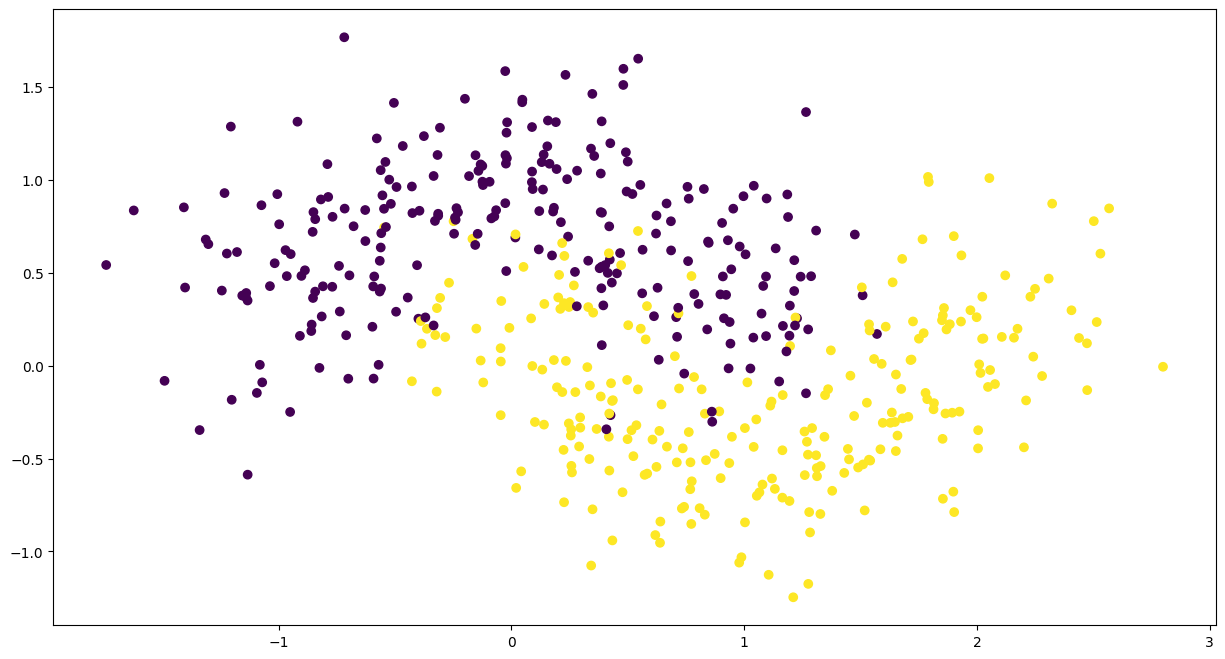

In [4]:
# Посмотрим на распределение данных
plt.scatter(X[:, 0], X[:, 1], c=y)

### Hard voting - практический смысл подхода:

- Строим несколько простых моделей на одних и тех же данных.
- Делаем предсказание всеми моделями.
- В качестве предсказания выбирается тот класс, за который проголосовало большинство моделей - **hard voting**

In [5]:
# Реализация классификатора лежит в ensemle объект VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Hard Voting Classifier:
from sklearn.ensemble import VotingClassifier

# Инициализируем несколько моделей Логистический Классификатор, Random Forest и Опорные вектора:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

# И соответственно сложим их в VotingClassifier Pipeline для того, чтобы делать предсказания
voting_clf = VotingClassifier(

    estimators= [('lr', log_clf),
                 ('rf', rnd_clf),
                 ('svc', svm_clf)],

    voting='hard')

# Обучим ансамбль простых моделей к hard-voting классификаторе
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [6]:
from sklearn.metrics import accuracy_score

# Для каждого классификатора в нашем ансамбле мы можем вывести индивидуальные метрики качества модели:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### Soft voting


Если все классификаторы могут вернуть вероятность (то есть, реализован метод predict proba), то мы можем посчитать среднее (среднюю вероятность предсказания) - **soft voting**
В Soft Voting Classifier идут только те модели, которые способны возвращать предсказание в качестве вероятности. Вывод делается на основе среднего значения по показателям вероятностей принадлежности к классу, побеждает тот, чья средняя вероятность будет выше по сравнению со средней вероятностью иных классов в ансамбле.


In [7]:
# Как и выше создадим экземпляры 3 моделей
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)


voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),
                ('rf', rnd_clf),
                ('svc', svm_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


In [12]:
print(voting_clf.predict_proba(X_test))

[[0.51627522 0.48372478]
 [0.75554677 0.24445323]
 [0.68916396 0.31083604]
 [0.019421   0.980579  ]
 [0.06317928 0.93682072]
 [0.11442562 0.88557438]
 [0.98184223 0.01815777]
 [0.97614735 0.02385265]
 [0.67591976 0.32408024]
 [0.96789922 0.03210078]
 [0.01266336 0.98733664]
 [0.9817691  0.0182309 ]
 [0.07838561 0.92161439]
 [0.17607193 0.82392807]
 [0.04381091 0.95618909]
 [0.93950502 0.06049498]
 [0.97581198 0.02418802]
 [0.03742245 0.96257755]
 [0.14783905 0.85216095]
 [0.92762252 0.07237748]
 [0.94099766 0.05900234]
 [0.14850351 0.85149649]
 [0.47582201 0.52417799]
 [0.85391568 0.14608432]
 [0.90187943 0.09812057]
 [0.84527399 0.15472601]
 [0.17452087 0.82547913]
 [0.98250382 0.01749618]
 [0.04136213 0.95863787]
 [0.97167451 0.02832549]
 [0.0190456  0.9809544 ]
 [0.0066318  0.9933682 ]
 [0.90099592 0.09900408]
 [0.97547669 0.02452331]
 [0.03431994 0.96568006]
 [0.66799065 0.33200935]
 [0.97584325 0.02415675]
 [0.01729993 0.98270007]
 [0.02909165 0.97090835]
 [0.02201933 0.97798067]


На датасете цветков ириса:

In [10]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1),
                                    ('rf', clf2),
                                    ('gnb', clf3)],
                        voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.953 (+/- 0.04) [Logistic Regression]
Accuracy: 0.940 (+/- 0.04) [Random Forest]
Accuracy: 0.913 (+/- 0.04) [naive Bayes]
Accuracy: 0.953 (+/- 0.04) [Ensemble]


In [11]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Загрузим датасет цветков ириса для классификации
iris = datasets.load_iris()
X = iris.data[:, [0,2]]
y = iris.target

# Создадим уже 4 экземпляра наших моделей
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[1, 1, 1])

# Обучим модели
clf1 = clf1.fit(X,y)
clf2 = clf2.fit(X,y)
clf3 = clf3.fit(X,y)
eclf = eclf.fit(X,y)

# И посмотрим на результаты, Что произошло?
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.927 (+/- 0.07) [Logistic Regression]
Accuracy: 0.940 (+/- 0.04) [Random Forest]
Accuracy: 0.947 (+/- 0.03) [naive Bayes]
Accuracy: 0.940 (+/- 0.06) [Ensemble]


### Подбор параметров

In [13]:
from sklearn.model_selection import GridSearchCV

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1),
                                    ('rf', clf2),
                                    ('gnb', clf3)],
                        voting='soft')

params = {'lr__C': [1.0, 100.0],
          'rf__n_estimators': [20, 200],}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid = grid.fit(iris.data, iris.target)

In [14]:
grid.best_estimator_

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=1)),
                             ('rf',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=1)),
                             ('gnb', GaussianNB())],
                 voting='soft')

## Bootstrap

Bootstrap (бутстреп) - $N$ раз выбираются случайные наблюдения с повторением из выборки. Генерируются $М$ подвыборок (бутстрап сэмплы) $X_1, X_2,...,X_m$. Теперь по каждой из выборок мы можем оценивать различные статистики (бутстрап статистики), которые нас интересуют.

Понимание метода бутстрапа важно, для того, чтобы дальше понять метод бэггинга.

!<img src='./pics/bts.png'>

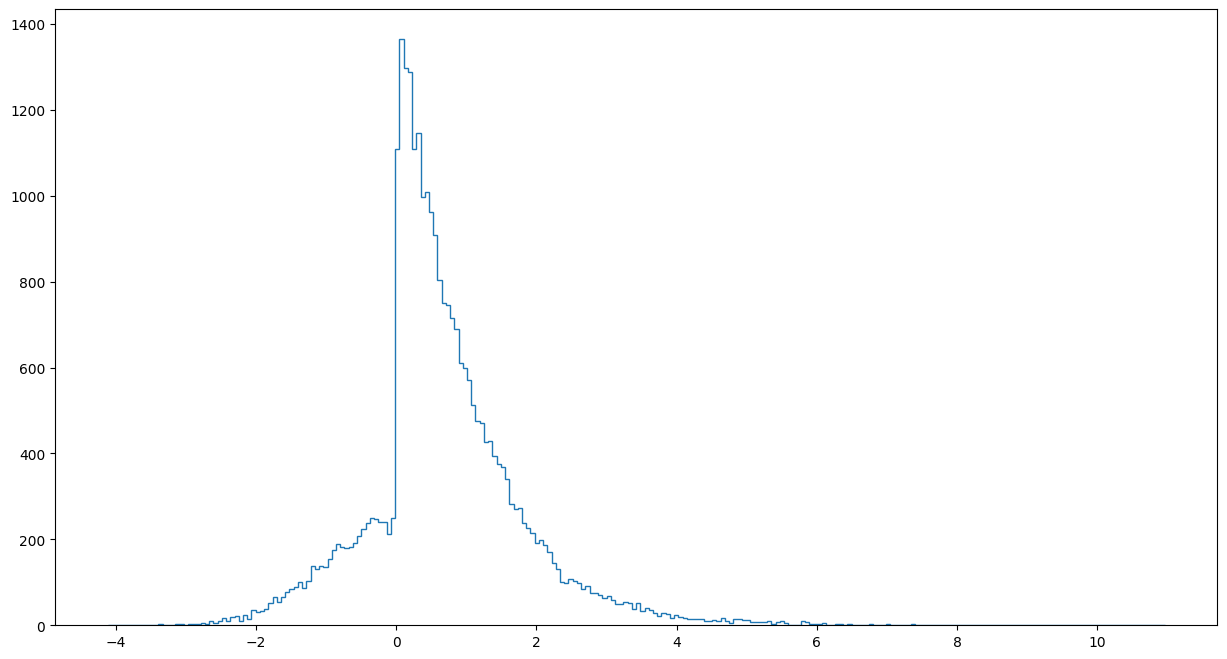

In [13]:
# Посмотрим как это выглядит на данных, предположим что у нас элементы из 2-х разных распределений, объединим и посмотрим на распределение:
x = np.concatenate([np.random.exponential(size=20_000), np.random.normal(size=10_000)])
plt.hist(x, 250, histtype='step');

In [14]:
# Теперь методом бутстрапирования получим 95% интервал для средних статистик в нашей сгенерированной выборке
n = len(x)

# Количество повторений
reps = 10000

# Случайная выборка (бутстрап)
xb = np.random.choice(x, (n, reps))

# Расчет средней статистики
mb = xb.mean(axis=0)
mb.sort()

print(np.percentile(mb, [2.5, 97.5]))

[0.65375351 0.67853873]


# Bagging - bootstrap aggregation

Из выборки генерируем сэмпл. Сэмплирование делаем с возвращением. Бэггинг по сути аггрегация метода бутстрапа. Сэмплирование также делается с возвращением.

Идея бэггинга - построить некоторые независимые модели и скомбинировать их, для того, чтобы использовать множество моделей, которые не будут коррелировать между собой и тем самым мы будем решать задачу уменьшения дисперсии в предсказаниях. Один из вариантов бэггинга модель Random Forest.

In [15]:
def subsample(data, ratio=1.0):
    return np.random.choice(data, size=int(data.shape[0] * ratio), replace=True)

In [16]:
dataset = np.random.randint(0, 100_000, size=50_000)

In [17]:
print(dataset[100:120])

[85792 34913 22831 34929 12086 25457 79548 93946 84867 26300  5066 52244
 77242 98283 80721 94394 70517 10740 14668 13162]


In [19]:
print(np.unique(np.bincount(dataset)))

[0 1 2 3 4 5 6]


In [20]:
sample = subsample(dataset, ratio=0.4)

In [21]:
print(sample)

[34104 86426 97904 ... 84479  6542 39031]


In [22]:
print(np.unique(np.bincount(sample)))

[0 1 2 3 4 5 6 7]


In [23]:
means = []
n_iterations = 1000

for i in range(n_iterations):
    sample = subsample(dataset, ratio=0.4)
    mean = sample.mean()
    means.append(mean)

sum(means) / n_iterations

49998.635390700016

In [24]:
dataset.mean()

50006.5618

Основные идеи бэггинга и шаги:
* Сгенерировать подвыборку с возвращением.
* Обучить модель.
* Для обучения будем использовать один и тот же алгоритм.
* Повторить много раз
* Для нового примера сделать предсказание и сагрегировать результат (например, вычислить моду - самое частое или среднее предсказание)

Можно обучать параллельлно

### Вопрос:
#### Какую компоненту ошибки уменьшает бэггинг?

http://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


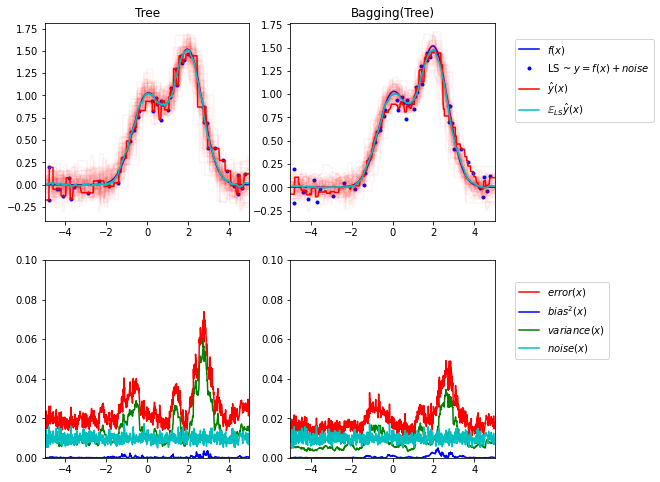

In [26]:
# Посмотрим на результат бэггинга для моделей. Реализация взята с документации scikit-learn:
# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)

# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))
        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

### Пример из scikit learn

Посмотрим на реализацию и использование объектов scikit learn для применения Bagging

In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True, 
    n_jobs=-1, 
    random_state=42
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [28]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [29]:
tree_clf = DecisionTreeClassifier(random_state=42)

tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [30]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

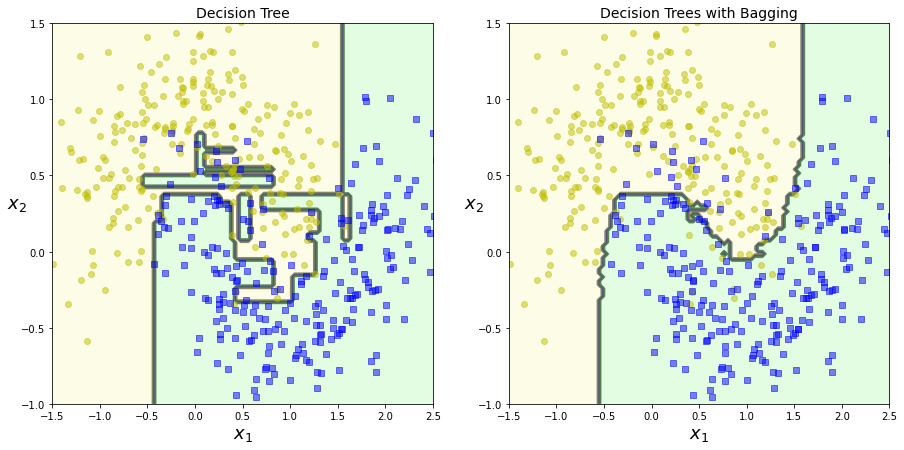

In [31]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

## Random subspace method

2 метода формирования случайного признакового пространства:
1. RSM
2. RPM


RSM Идея: брать случайные признаки.

| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|2  | 0.2  | 0.02  |  20 |
|3   |  0.3 | 0.03  | 30  |
|4   |  0.4 |  0.04 | 40  |

| idx | a |c |
|---|---|---|
|1   | 0.1  |10  |
|2  | 0.2  | 20 |
|3   |  0.3 | 30  |
|4   |  0.4 | 40  |

| idx | a | b | 
|---|---|---|
|1   | 0.1  | 0.01  |
|2  | 0.2  | 0.02  |
|3   |  0.3 | 0.03  |
|4   |  0.4 |  0.04 |

* bootstrap=False
* max_samples=1.0
* bootstrap_features=True
* max_features < 1.0

## Random Patches method

Брать случайные признаки и случайные примеры

* bootstrap=True
* max_samples= < 1.0
* bootstrap_features=True
* max_features < 1.0

| idx | a | b | c |
|---|---|---|---|
|1   | 0.1  | 0.01  | 10  |
|2  | 0.2  | 0.02  |  20 |
|3   |  0.3 | 0.03  | 30  |
|4   |  0.4 |  0.04 | 40  |

| idx | a |c |
|---|---|---|
|2  | 0.2  | 20 |
|4   |  0.4 | 40  |

| idx | a | b | 
|---|---|---|
|2  | 0.2  | 0.02  |
|3   |  0.3 | 0.03  |

## Random forest

1. $X_1, X_2, ..., X_N$ -- объекты выборки, $f_1, f_2, ..., f_M$ -- признаки
2. $n_{models}$ -- количество моделей в ансамбле
3. Для каждой модели выбираем количество признаков $m \le M$
4. Для каждой из моделей бутстрэпим выборку и обучаем модель на ней
5. Результатом работы случайного леса будет усредненное значение результатов отдельных моделей.

Параметры RandomForestRegressor-a:
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [32]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [33]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [34]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [35]:
np.sum(y_pred == y_pred_rf) * 1. / len(y_pred)  # almost identical predictions

0.976

In [36]:
np.sum(y_pred == y_pred_rf) * 1. / len(y_pred)  # almost identical predictions

0.976

### Ирисы и важность признаков у случайного леса

In [37]:
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [38]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

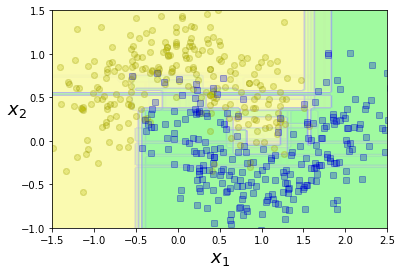

In [39]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show();

# Out-of-bag error

Каждое дерево строится с использованием разных образцов бутстрэпа из исходных данных. Примерно 37% примеров остаются вне выборки бутстрэпа и не используются при построении k-го дерева.


Out of bag error усредненная ошибка на 37% не используемых примерах.

# Важность признаков

### Упражнение
Как определить наиболее важные признаки?

## Замечание
- Чем выше признак, тем выше его важность.
- При оценке ошибки методом out-of-bag error можно сравнивать 2 различных набора признаков

Для того, чтобы оценить важность j-го параметра после тренировки, значения j-го параметра перемешиваются для всех записей тренировочного набора и out-of-bag-ошибка считается снова. Важность параметра оценивается путём усреднения по всем деревьям разности показателей out-of-bag-ошибок до и после перемешивания значений. При этом значения таких ошибок нормализуются на стандартное отклонение.

In [25]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [26]:
mnist["data"].shape

(70000, 784)

In [27]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [28]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

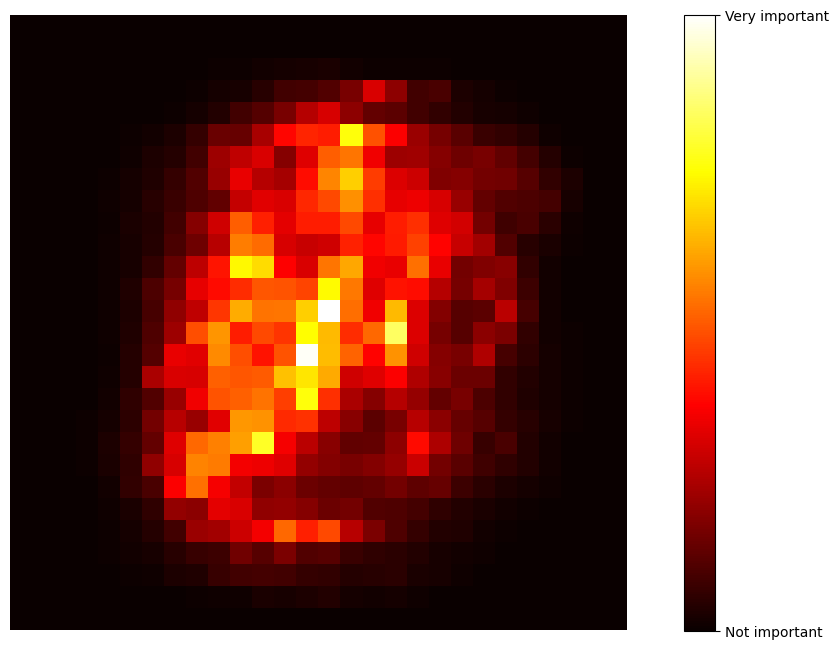

In [29]:
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

# Extremely Randomized Trees

Идея: Случайным образом выбирать порог для разбиения в узлах деревьев (случайный набор порогов -> выбираем лучший порог)

Сэмплы генерируются от всего тренировочного сета.

In [30]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

ex_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
ex_clf.fit(X_train, y_train)

y_pred_ex = ex_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_ex))

0.912
0.912


## Плюсы и минусы


### Плюсы
\+ RandomForest во многих задачах является сильным бейзлайном <br>
\+ хорошо работает на больших выборках (много признаков/много данных) <br>
\+ не сильно чувствителен к изменению параметров <br>
\+ не чувствителен к выбросам в данных из-за случайного сэмлирования <br>
\+ возвращает важности отдельных признаков <br>
\+ параллелизуется <br>
\+ не склонен к переобучению <br>

### Минусы
\- плохо работает на разреженных выборках <br>
\- занимает много памяти <br>
\- плохо интерпретируются <br>

# Boosting

* Обучить модель
* Посчитать ошибки
* Учесть ошибки и обучить новую модель
* Повторять некоторое количество раз

Нельзя обучать параллельно

# AdaBoost
Будем влиять на вес тренировочных примеров, участвующих в обучении.  
Из этих весов сможем рассчитывать вес модели

In [41]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5,
    random_state=42)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

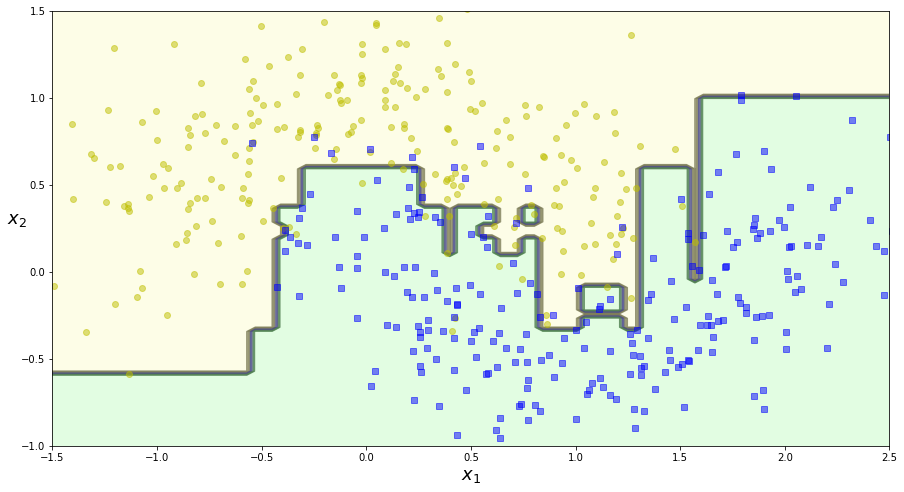

In [42]:
plot_decision_boundary(ada_clf, X, y)

Веса $w_i$ каждого обучающего примера $X_i$
$$X = \begin{bmatrix} 
a_1 & b_1 & c_1 & ... \\ 
a_2 & b_2 & c_2 & ... \\ 
a_3 & b_3 & c_3 & ... \\
... & ... & ... & ...
\end{bmatrix},
w = \begin{bmatrix} 
w_1 \\ 
w_2 \\ 
w_3 \\
... 
\end{bmatrix}$$

initially

$$w_i = \frac{1}{m}$$


$m$ - количество примеров в обучающей выборке (количество строк в $X$)

Обучаем модель и считаем ее error rate:


$$r = \frac{\sum\limits_{\hat{y} \neq y}{w}}{\sum w}$$

Чем больше ошибок, тем больше $r$

Считаем вес модели:

$$ \alpha = \eta log \frac{1-r}{r} $$

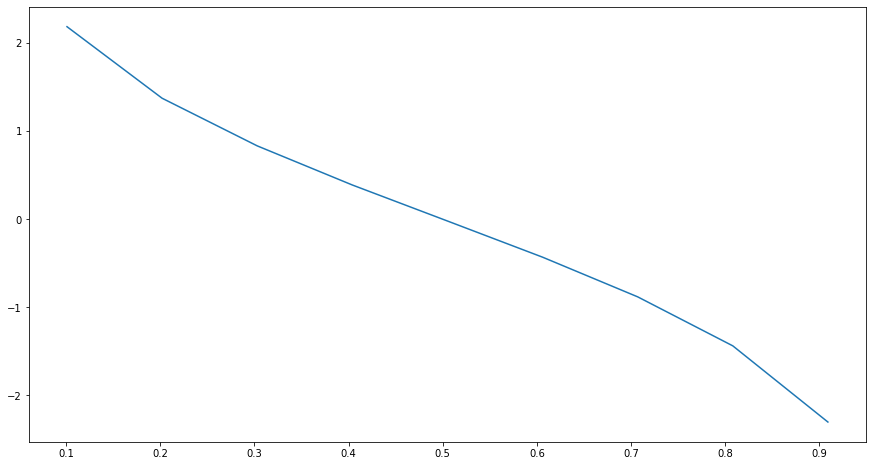

In [43]:
def f(x):
    return np.log((1 - x) / x)

x = np.linspace(0, 10, 100)
y = f(x)
plt.plot(x, y)

Обновим веса:

$w$ не меняется, если предсказание верное   
$w \leftarrow w \cdot e^{\alpha} $, если предсказание ошибочное

Все веса нормализуются, делятся на $\sum w$

![img](./pics/stacking.png)

Стэккинг и Блендинг довольно популярные методики в классическом машинном обучении в сложных нетривиальных задачах. Большая часть призовых мест на Kaggle была получена с использованием методов Стэккинга и Блендинга.

Блендинг: у нас есть выборка (датасет, Х и у). Мы берем стандартный процесс разделения выборки train-test-split и с этого момента начинается процесс Блендинга. Мы пока не трогаем тестовую часть выборки, а работаем только с тренировочной выборкой.

Тренировочная выборка в свою очередь делится еще на 2 части - на 1-ой части обучаем наши базовые алгоритмы и на 2-й части мы получаем результаты, то есть ответы нашего предсказательной модели. Так же мы это делаем и на тестовой выборке, которая у нас осталась в запасе.

В данном случае результаты ответа нашего алгоритма можно рассматривать как некий новый признак, который у нас получился и на этих новых признаках (которые мы получили в 1-м шаге) наступает момент 2-го шага - настраивается алгоритм на новых признаках и получаем ответ.

Недостаток блендинга - деление выборки.

In [44]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [45]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

X_in, X_out, y_in, y_out = train_test_split(X_train, y_train, random_state=42) # hold-out - blending. 

In [46]:
svm_clf.fit(X_in, y_in)
rnd_clf.fit(X_in, y_in)

svm_y = svm_clf.predict(X_out)
rnd_y = rnd_clf.predict(X_out)

In [47]:
log_clf.fit(np.c_[svm_y, rnd_y], y_out)

LogisticRegression(random_state=42)

In [48]:
y_stack = log_clf.predict(np.c_[svm_clf.predict(X_test), rnd_clf.predict(X_test)])

In [49]:
accuracy_score(y_test, y_stack)

0.896

In [50]:
accuracy_score(y_test, rnd_clf.predict(X_test))

0.92

## Задача:
есть несколько базовых алгоритмов SVM, KNN, DecisionTree и несколько способов их композиции бэггинг, бустинг.
Для каких базовых алгоритмов какие способы композиции будут работать лучше? При необходимости нужно провести эксперименты.

## Дополнительные материалы:
[Bias Variance tradeoff](https://en.wikipedia.org/wiki/Bias–variance_tradeoff)

http://scott.fortmann-roe.com/docs/BiasVariance.html

[Заметка А.Дьяконова о случайных лесах](https://dyakonov.org/2016/11/14/случайный-лес-random-forest/)

[Статья А.Дьяконова про блендинг и стекинг](https://dyakonov.org/2017/03/10/cтекинг-stacking-и-блендинг-blending/)